In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle as pkl
import sys
import matplotlib.pyplot as plt
from torchvision import utils
sys.path.append('../..')
from evaluation.scripts.evaluate import eval_model_averages, create_loaders
from pytorch_lightning.callbacks import Callback

class AutopickleModel(Callback): #Thing that was helping with pickling is also messing up pickling, how delightful
    def __init__(self, model):
        self.model = model

    def on_validation_epoch_end(self, trainer, module):
        model_file = open(args.save_path, 'wb')
        # The base model should not need it anymore- and it's a bit messing up pickling
        self.model.base_model.train_dataloader = None
        self.model.base_model.val_dataloader = None
        self.model.base_model.trainer = None
        pkl.dump(self.model, model_file)
        model_file.close()

In [2]:
DATASET_DIRECTORY = '/home/macron/Praca Magisterska/Dane/'

loaders, datasets = create_loaders(DATASET_DIRECTORY)


/home/macron/Praca Magisterska/Dane//mixed_next
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Dane//mixed_rand
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Dane//only_fg
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Dane//original
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Dane//no_fg
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Dane//only_bg_t
==> Preparing dataset ImageNet9..


In [4]:
MODEL_PATHS = ['/home/macron/Praca Magisterska/Gotowe Sieci/clean.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_3ep_start_epclear_nolimit.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_100emb_conv.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb_conv.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_nf.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_nf.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb_512z.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_100emb_512z.pkl',]
cached = {'clean' : [51.61290322580645, 58.11230585424134, 62.81959378733573, 88.1242532855436, 59.66547192353644, 40.38231780167264],
          'flow_3ep_start_epclear_nolimit' : [18.16009557945042, 18.805256869773, 20.023894862604543, 25.113500597371562, 19.0442054958184, 17.013142174432495],
          'flow_nice_30ep_100emb_conv' : [56.511350059737154, 56.8936678614098, 62.078853046594986, 66.23655913978494, 35.31660692951015, 16.439665471923536],
          'flow_nice_77ep_256emb_conv' : [52.162485065710875, 52.520908004778974, 59.11589008363202, 63.106332138590204, 31.49342891278375, 16.7741935483871],
          'flow_nice_77ep_nf' : [83.53643966547193, 83.67980884109917, 89.58183990442055, 95.65113500597371, 54.33691756272402, 24.492234169653525],
          'flow_nice_30ep_nf' : [83.584229390681, 83.65591397849462, 89.17562724014337, 95.43608124253285, 56.821983273596175, 21.648745519713263],
          'flow_nice_77ep_256emb_512z' : [67.3357228195938, 68.55436081242533, 76.6547192353644, 82.389486260454, 34.81481481481482, 17.156511350059738],
          'flow_nice_30ep_100emb_512z' : [76.20071684587813, 76.43966547192353, 82.24611708482676, 89.41457586618877, 44.25328554360812, 17.8494623655914],
         }
force = False

results = {}
for path in MODEL_PATHS:
    model_name = path.split('/')[-1].replace('.pkl', '')
    if model_name in cached and not force:
        results[model_name] = cached[model_name]
        continue
    model_file = open(path, 'rb')
    
    model = pkl.load(model_file)
    model_file.close()
    model.cuda()
    avg = eval_model_averages(loaders, model)
    
    print(f'Model {model_name}: {avg}')
    results[model_name] = avg

100%|███████████████████████████████████████| 1047/1047 [01:05<00:00, 16.08it/s]


Model flow_nice_30ep_100emb_512z: [76.20071684587813, 76.43966547192353, 82.24611708482676, 89.41457586618877, 44.25328554360812, 17.8494623655914]


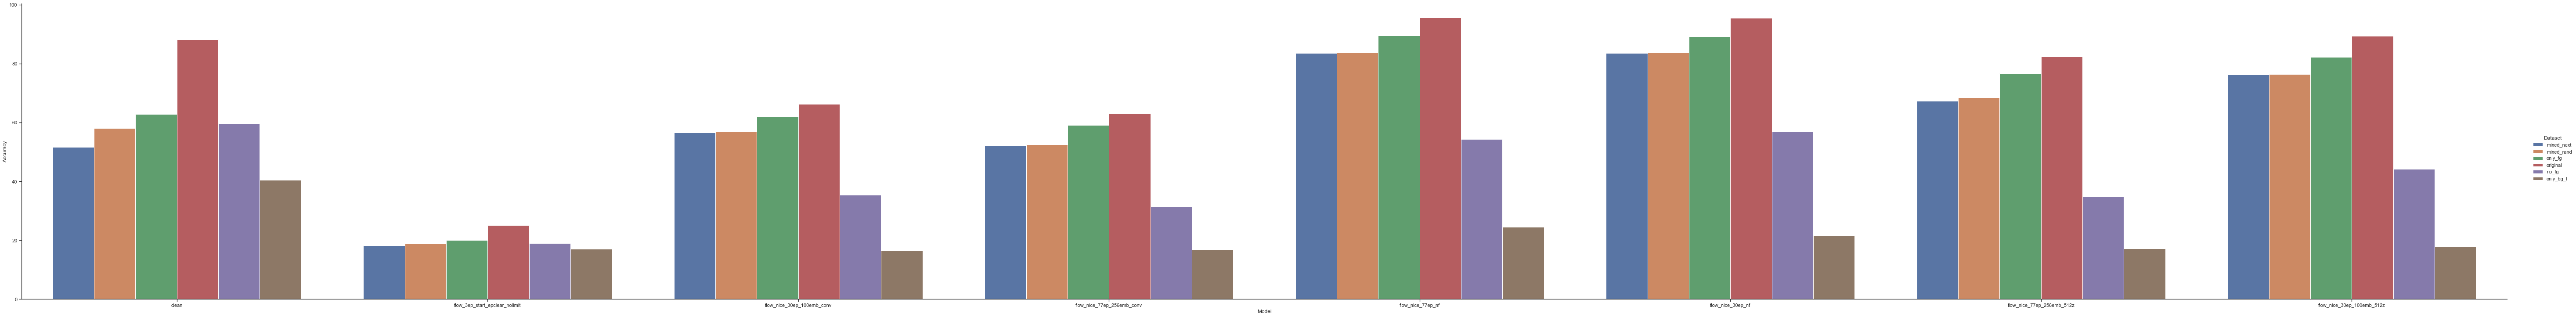

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

vv = {'Model' : [], 'Accuracy' : [], 'Dataset' : []}
names = []
for md in results:
    for dataset_name, value in zip([dt.split('/')[-1] for dt in datasets], results[md]):
        vv['Accuracy'].append(value)
        vv['Model'].append(md)
        vv['Dataset'].append(dataset_name)

sns.catplot(x="Model", y="Accuracy", hue="Dataset", kind="bar", data=pd.DataFrame(vv), aspect=len(results), height=10.)
pass